In [1]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pystan
import seaborn as sns
import arviz as az
import corner
import time

In [2]:
data=pd.read_csv("JPN-HIV-AIDS.csv",header=None)

In [3]:
y_obs_tmp=data[[1,2]]
y_obs=y_obs_tmp.to_numpy()

In [4]:
#az.style.use("arviz-darkgrid")

NumIter = 10000
burnin  = 5000


save_results_to = 'JPN_BayesSens/'

times = np.linspace(0, y_obs.shape[0]-1, y_obs.shape[0])
N=len(times)
small_times = np.linspace(0, N-1 ,10*N+1)


pred_days  = N+2
times_pred = np.linspace(0, pred_days,pred_days +1 ) 
times_pred_small = np.linspace(0, pred_days,(pred_days+1)*10 +1 ) 

pop = 126317000         # Population 

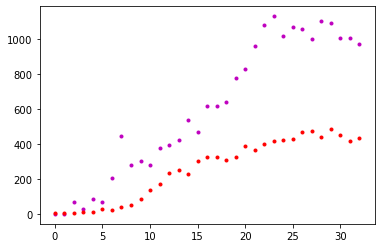

In [5]:
fig0= plt.figure()
plt.plot(times, y_obs[:,0],'m.', times, y_obs[:,1],'r.')
#plt.show()
plt.savefig( save_results_to + 'HIV-AIDS_cases.eps')

In [6]:
mydata = {}
mydata['n_obs']       = len(times)
mydata['n_small']     = len(small_times)
mydata['n_small_pred']= len(times_pred_small)
mydata['n_theta']     = 4
mydata['n_difeq']     = 3
mydata['n_pop']       = pop
mydata['y']           = y_obs
mydata['t0']          = -0.000001
mydata['n_fake']      = len(times_pred)
mydata['fake_ts']     = times_pred_small
mydata['tsm']         = small_times
mydata['ts']          = times

In [82]:
beta_mu = 0.
beta_sd = 1.5
beta_stan = 'lognormal({mu}, {sigma})'.format(mu=beta_mu, sigma=beta_sd)


sigma_low  = 0
sigma_high = 1
sigma_stan = 'uniform({mu}, {sd})'.format(mu=sigma_low, sd=sigma_high)


Karga1_low  = 0
Karga1_high = 3
Karga1_stan = 'uniform({mu}, {sd})'.format(mu=Karga1_low, sd=Karga1_high)


Karga2_low  = 0
Karga2_high = 3
Karga2_stan = 'uniform({mu}, {sd})'.format(mu=Karga2_low, sd=Karga2_high)

In [83]:
# Fit
stan_code = """
functions {{
  real[] SIR(real t,  // time
  real[] y,           // system state {{susceptible,infected,recovered}}
  real[] theta,       // parameters
  real[] x_r,
  int[] x_i) {{
  
  real mu= 0.0077;
  real nu= 0.0098;



  real xi1     =  1e-4;
  real xi2     =  1e-6;
  real kappa  =  0.00003;
  
  real beta   = theta[1];
  real sigma  = theta[2];
  real Karga1 = theta[3];
  real Karga2 = theta[4];
  
  real dy_dt[3];
  
  dy_dt[1] =  mu -(beta*y[2] + nu + xi1  )*y[1];
  dy_dt[2]  =(beta* y[2] + xi1 ) *y[1] - (sigma + nu  - xi2)*y[2];
  dy_dt[3] = (sigma -xi2)* y[2] - (kappa + nu)*y[3];
  
  return dy_dt;
  }}
  
  }}
  data {{
  
    int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_small;       // number of days observed
  int<lower = 1> n_small_pred;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations
  int<lower = 1> n_pop;       // population 
  int y[n_obs,(n_difeq-1)];           // data, total number of infected individuals each day
  real t0;                // initial time point (zero)
  real ts[n_obs];         // time points observed
  real tsm[n_small];         // time points observed
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  real fake_ts[n_small_pred]; // Time points for "predicted"/"unsampled" data
  
  }}
  
  transformed data {{
  real x_r[0];
  int x_i[0];
  }}
  
  parameters {{

  real<lower =  0, upper = 1.5> beta ;
  real<lower =  0, upper = 1.> sigma ;
  real<lower =  0, upper = 3.> Karga1 ;
  real<lower =  0, upper = 3.> Karga2 ;


  
  }}
  
  transformed parameters{{
  
  real y_hat[n_obs,(n_difeq-1)]; // solution from the ODE solver
  real y_hat_sm[n_small, n_difeq]; // solution from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I
  real theta[n_theta];   // {{ alpha, beta, gamma, delta }}
  
  real S0;
  real I0;
  real A0;
  real lambda1[n_obs];
  real lambda2[n_obs];
  real rho1[n_obs]; 
  real rho2[n_obs];
  vector[11] weights;
  vector[11] incidence1;
  vector[11] incidence2;
  real dt=1./(10*n_obs);
  real xi1=1e-4;
  real xi2=1e-6;

  
  S0 = 0.999999952;
  I0 = 8e-9;
  A0 = 4e-8;
  

  y_init[1] = S0;
  y_init[2] = I0;
  y_init[3] = A0;
  
  
  theta[1] = beta;
  theta[2] = sigma;
  theta[3] = Karga1;
  theta[4] = Karga2;

  
  y_hat_sm = integrate_ode_rk45(SIR, y_init, t0, tsm, theta, x_r, x_i);

  
 weights[1]=0.5;
 weights[11]=0.5;
 
 for (i in 2:10){{
     weights[i] = 1.0;
  }}

 
  for (i in 1:n_obs){{
      lambda1[i] = 0.0;
      lambda2[i] = 0.0;
      for (k in 1:11){{
       incidence1[k] = (beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incidence2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];
       lambda1[i]    = lambda1[i] + dt*weights[k]*incidence1[k];
       lambda2[i]    = lambda2[i] + dt*weights[k]*incidence2[k];
      }}
  y_hat[i,1]=n_pop*Karga1*lambda1[i];
  y_hat[i,2]=n_pop*Karga2*lambda2[i];
 }}
    


  }}
  
  
  model {{
  
  real lamb1[n_obs];      //poisson parameter
  real lamb2[n_obs];      //poisson parameter
  real rhho1[n_obs];      //poisson parameter
  real rhho2[n_obs];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_obs);
  real xii1 =1e-4;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  //priors
  beta     ~ lognormal(0, 1.5);
  sigma    ~ uniform(0.0, 1.0 );
  Karga1   ~ uniform(0.0, 3 );
  Karga2   ~ uniform(0.0, 3);

  
  
  //likelihood
  for (i in 1:(n_obs)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( beta*y_hat_sm[k + 10*(i-1),2] + xii1 )*y_hat_sm[k + 10*(i-1),1];
       incid2[k] = ( sigma- xii2 )*y_hat_sm[k + 10*(i-1),2];       
       lamb1[i]    = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]    = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i] = n_pop*Karga1*lamb1[i];
  rhho2[i] = n_pop*Karga2*lamb2[i]; 
  y[i , 1] ~ poisson(rhho1[i]);
  y[i , 2] ~ poisson(rhho2[i]);
  }}
 
  }}
  
  generated quantities {{
  real R_0;      // Basic reproduction number
  real nu= 0.0098;
//  real population=10649800;
  real epsilon = 1e-9;
  real fake[n_fake, 2];
  real <lower = 0.> y_hat_pred[n_small_pred, n_difeq]; // Output from the ODE solver
  
  real lamb1[n_fake];      //poisson parameter
  real lamb2[n_fake];      //poisson parameter
  real rhho1[n_fake];      //poisson parameter
  real rhho2[n_fake];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_fake);
  real xii1 =1e-5;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  y_hat_pred = integrate_ode_rk45(SIR, y_init, t0, fake_ts, theta, x_r, x_i);  
  
    //likelihood
  for (i in 1:(n_fake)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( theta[1]*y_hat_pred[k + 10*(i-1),2] + xii1 )*y_hat_pred[k + 10*(i-1),1];
       incid2[k] = ( theta[2]- xii2 )*y_hat_pred[k + 10*(i-1),2];       
       lamb1[i]   = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]   = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i]=n_pop*theta[3]*lamb1[i];
  rhho2[i]=n_pop*theta[4]*lamb2[i];
  fake[i , 1] = poisson_rng( rhho1[i] );
  fake[i , 2] = poisson_rng( rhho2[i] );
 
  }}
  
  
  R_0 = theta[1]/(theta[2] + nu);
  }}
""".format(
        beta   =beta_stan,
        sigma  =sigma_stan,
        Karga1 =Karga1_stan,
        Karga2 =Karga2_stan
        )

In [84]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a2936407b2c7a2a644df34ea086c24d1 NOW.


--- 31.2570481300354 seconds ---


In [85]:
# do the fitting
start_time = time.time()
fit = sm.sampling(
                  data=mydata,
                  iter=NumIter,
                  chains=6,
                  warmup=burnin,
                  seed=431,
                  verbose=True,
                  algorithm='NUTS',
                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--- 249.44000053405762 seconds ---


In [86]:
varnames = ["beta", "sigma", "Karga1", "Karga2","R_0"]
summary=fit.summary(pars=varnames, probs=(0.025, 0.25, 0.5, 0.75, 0.975))

In [87]:
df_summary =  pd.DataFrame(
    summary['summary'],
    columns=summary['summary_colnames'],
    index=summary['summary_rownames']
)

fit_dict= fit.extract()
fit_df = fit.to_dataframe()

In [88]:
fit_dict= fit.extract()
fit_df = fit.to_dataframe()
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.074208,0.000126,0.011273,1.051514,1.066646,1.074482,1.081833,1.095895,8056.469859,1.000279
sigma,0.915996,0.000104,0.009805,0.896340,0.909413,0.916149,0.922608,0.934846,8836.432003,1.000343
Karga1,0.036365,0.000012,0.001152,0.034210,0.035570,0.036324,0.037138,0.038680,8544.878281,1.000579
Karga2,0.016532,0.000006,0.000551,0.015496,0.016147,0.016515,0.016900,0.017651,8553.584054,1.000517
R_0,1.160313,0.000032,0.003262,1.154012,1.158096,1.160307,1.162508,1.166717,10427.668918,1.000731


In [23]:
# with open('Table_JPN.tex','w') as tf:
#      tf.write(df_summary.to_latex())

In [24]:
data = az.from_pystan(
    posterior=fit,
    posterior_predictive="fake",
    observed_data=["y"],
)

data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> observed_data

<Figure size 432x288 with 0 Axes>

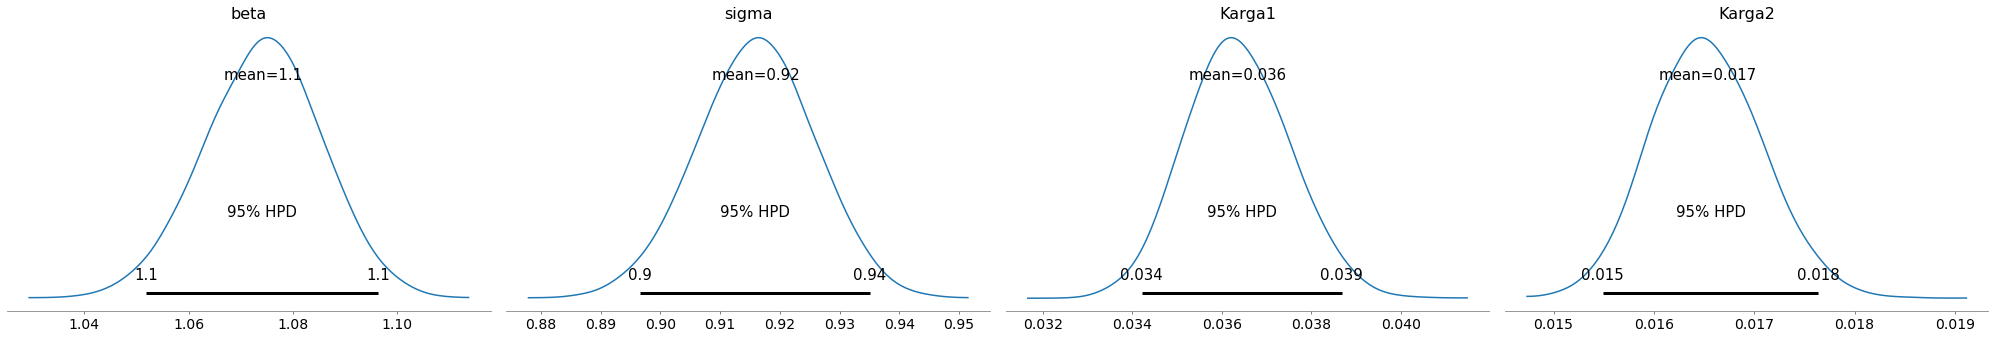

In [25]:
varnames = ["beta", "sigma", "Karga1", "Karga2"]
fig =plt.figure()
az.plot_posterior(data,var_names=varnames,credible_interval=0.95);
plt.savefig(save_results_to + 'credibleIntervalsAll_JPN.eps')

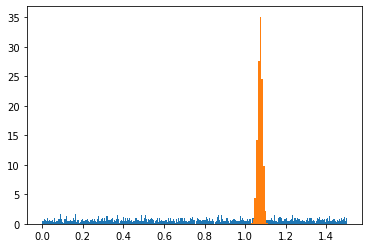

In [60]:
plt.figure()
#data=ss.gamma.rvs(alpha,loc=0.0,scale=beta,size=5000)
data_prior=ss.uniform.rvs(loc=0,scale=1.5,size=5000)
myHist = plt.hist(data_prior, 1000, density=True)
plt.hist(fit_dict['beta'],density=True)
#plt.xlim(0.0,1.0)
#plt.ylim(0.0,10.0)
plt.savefig(save_results_to + 'beta_prior_vs_posterior.eps')

/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/kernel/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument

<Figure size 432x288 with 0 Axes>

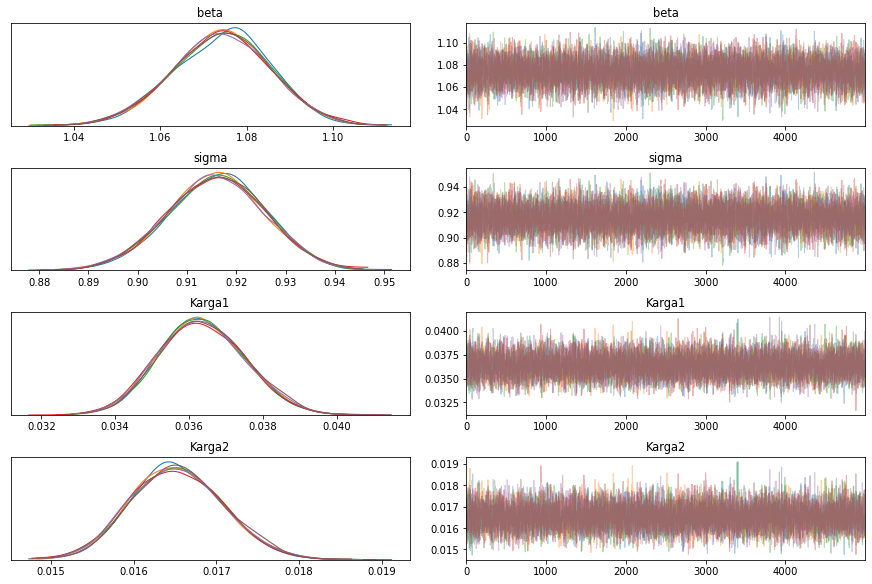

In [18]:
inference_data = az.from_pystan(fit)
plt.figure()
az.plot_trace(inference_data,var_names= varnames)
plt.savefig(save_results_to +'TraceAll_JPN.pdf')

In [89]:
weakInform_beta   =fit_df['beta']
weakInform_sigma  =fit_df['sigma']
weakInform_Karga1 =fit_df['Karga1']
weakInform_Karga2 =fit_df['Karga2']

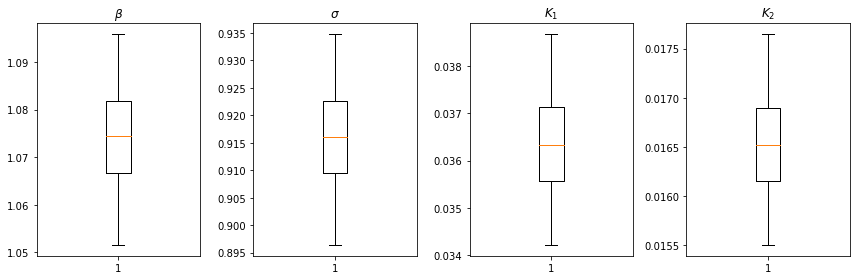

In [19]:
fig, axs = plt.subplots(1, 4,figsize=(12, 4))
axs[0].boxplot(fit_df['beta'],whis=(2.5,97.5), sym='')
axs[0].set_title(r'$\beta$')

axs[1].boxplot(fit_df['sigma'],whis=(2.5,97.5), sym='')
axs[1].set_title(r'$\sigma$')

axs[2].boxplot(fit_df['Karga1'],whis=(2.5,97.5), sym='')
axs[2].set_title(r'$K_1$')

axs[3].boxplot(fit_df['Karga2'],whis=(2.5,97.5), sym='')
axs[3].set_title(r'$K_2$')

plt.tight_layout()
plt.savefig(save_results_to+'Box_Params_JPN.pdf')

In [90]:
median_ppc = np.percentile(fit_dict['fake'],q=50.,axis=0)
CriL_ppc   = np.percentile(fit_dict['fake'],q=2.5,axis=0)
CriU_ppc   = np.percentile(fit_dict['fake'],q=97.5,axis=0)

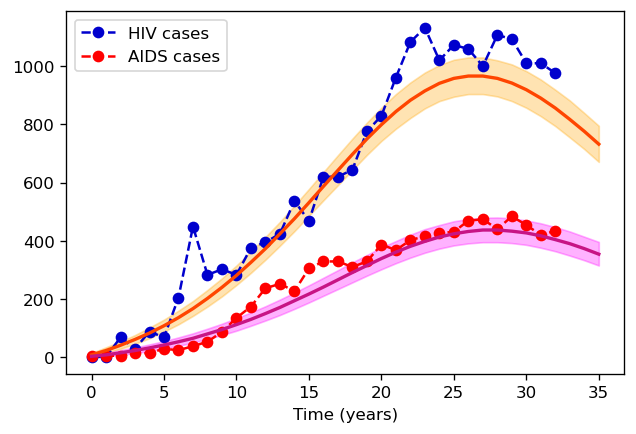

In [91]:
fig, ax = plt.subplots(dpi=120)
ax.plot(times,y_obs[:,0], linestyle='dashed', marker='o', 
        color='mediumblue',label="HIV cases")
ax.plot(times,y_obs[:,1], linestyle='dashed', marker='o', 
        color='red',label="AIDS cases")
ax.plot(times_pred,median_ppc[:,0], color='orangered', lw=2)
ax.plot(times_pred,median_ppc[:,1], color='mediumvioletred', lw=2)
ax.fill_between(times_pred,CriL_ppc[:,0],CriU_ppc[:,0], color='orange', alpha=0.3)
ax.fill_between(times_pred,CriL_ppc[:,1],CriU_ppc[:,1], color='magenta', alpha=0.3)
ax.set_xlabel('Time (years)')  # Add an x-label to the axes.
#ax.set_ylabel('CFU/mlx10^8')  # Add a y-label to the axes.
#ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend(loc="upper left")  # Add a legend.
ax.figure.savefig(save_results_to +'PredictionBands_JPN.pdf')

In [23]:
pystan_trace = [fit_dict['beta'], fit_dict['sigma'], fit_dict['Karga1'],fit_dict['Karga2']]

In [24]:
trace=np.array(pystan_trace)
trace_df = pd.DataFrame(pystan_trace) 
map=np.median(trace,axis=1)
range = np.array([(0.5*x,1.5*x) for x in map])

<Figure size 432x288 with 0 Axes>

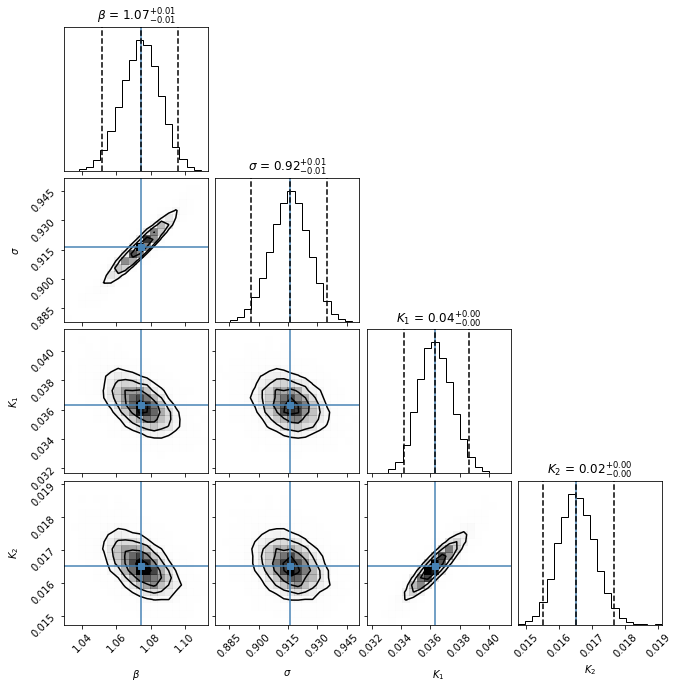

In [26]:
varnames=[r"$\beta$", r"$\sigma$" , r"$K_{1}$" , r"$K_{2}$"]
range = np.array([(0.1*x,1.9*x) for x in map])
#range=range
plt.figure()
corner.corner(trace_df.T,show_titles=True,labels=varnames,truths=map,
                    plot_datapoints=False,quantiles=[0.025, 0.5, 0.975])
plt.savefig(save_results_to +'corner2_JPN.pdf')

In [92]:
from IPython.display import display, Math
ppc_beta=np.percentile(fit_df['beta'],q=50,axis=0)
ppc_sigma=np.percentile(fit_df['sigma'],q=50,axis=0)
nu= 0.0073;
R_0 = ppc_beta/(ppc_sigma + nu)
display(Math(r'\beta: {}'.format(ppc_beta)))
display(Math(r'\sigma: {}'.format(ppc_sigma)))
display(Math(r'\nu: {}'.format(nu)))
print()
display(Math(r'R_0: {}'.format(R_0)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [93]:
def euclidean(v1, v2):
    return sum((q1-q2)**2 for q1, q2 in zip(v1, v2))**.5

In [94]:
print('Residuals of HIV cases =')
print(euclidean(median_ppc[:,0], y_obs[:,0]))
print('Residuals of AIDS cases =')
print(euclidean(median_ppc[:,1], y_obs[:,1]))
J_weakInform = (euclidean(median_ppc[:,0], y_obs[:,0]) + euclidean(median_ppc[:,1], y_obs[:,1])  )
print('J_weakInform =')
print(J_weakInform)

Residuals of HIV cases =
572.1616904337444
Residuals of AIDS cases =
225.9867252738532
J_weakInform =
798.1484157075977


In [65]:
beta_mu = 0.
beta_sd = 1.5
beta_stan = 'uniform({mu}, {sigma})'.format(mu=beta_mu, sigma=beta_sd)


sigma_low  = 0
sigma_high = 1
sigma_stan = 'uniform({mu}, {sd})'.format(mu=sigma_low, sd=sigma_high)


Karga1_low  = 0
Karga1_high = 3
Karga1_stan = 'uniform({mu}, {sd})'.format(mu=Karga1_low, sd=Karga1_high)


Karga2_low  = 0
Karga2_high = 3
Karga2_stan = 'uniform({mu}, {sd})'.format(mu=Karga2_low, sd=Karga2_high)

In [66]:
# Fit
stan_code = """
functions {{
  real[] SIR(real t,  // time
  real[] y,           // system state {{susceptible,infected,recovered}}
  real[] theta,       // parameters
  real[] x_r,
  int[] x_i) {{
  
  real mu= 0.0077;
  real nu= 0.0098;



  real xi1     =  1e-4;
  real xi2     =  1e-6;
  real kappa  =  0.00003;
  
  real beta   = theta[1];
  real sigma  = theta[2];
  real Karga1 = theta[3];
  real Karga2 = theta[4];
  
  real dy_dt[3];
  
  dy_dt[1] =  mu -(beta*y[2] + nu + xi1  )*y[1];
  dy_dt[2]  =(beta* y[2] + xi1 ) *y[1] - (sigma + nu  - xi2)*y[2];
  dy_dt[3] = (sigma -xi2)* y[2] - (kappa + nu)*y[3];
  
  return dy_dt;
  }}
  
  }}
  data {{
  
    int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_small;       // number of days observed
  int<lower = 1> n_small_pred;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations
  int<lower = 1> n_pop;       // population 
  int y[n_obs,(n_difeq-1)];           // data, total number of infected individuals each day
  real t0;                // initial time point (zero)
  real ts[n_obs];         // time points observed
  real tsm[n_small];         // time points observed
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  real fake_ts[n_small_pred]; // Time points for "predicted"/"unsampled" data
  
  }}
  
  transformed data {{
  real x_r[0];
  int x_i[0];
  }}
  
  parameters {{

  real<lower =  0, upper = 1.5> beta ;
  real<lower =  0, upper = 1.> sigma ;
  real<lower =  0, upper = 3.> Karga1 ;
  real<lower =  0, upper = 3.> Karga2 ;


  
  }}
  
  transformed parameters{{
  
  real y_hat[n_obs,(n_difeq-1)]; // solution from the ODE solver
  real y_hat_sm[n_small, n_difeq]; // solution from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I
  real theta[n_theta];   // {{ alpha, beta, gamma, delta }}
  
  real S0;
  real I0;
  real A0;
  real lambda1[n_obs];
  real lambda2[n_obs];
  real rho1[n_obs]; 
  real rho2[n_obs];
  vector[11] weights;
  vector[11] incidence1;
  vector[11] incidence2;
  real dt=1./(10*n_obs);
  real xi1=1e-4;
  real xi2=1e-6;

  
  S0 = 0.999999952;
  I0 = 8e-9;
  A0 = 4e-8;
  

  y_init[1] = S0;
  y_init[2] = I0;
  y_init[3] = A0;
  
  
  theta[1] = beta;
  theta[2] = sigma;
  theta[3] = Karga1;
  theta[4] = Karga2;

  
  y_hat_sm = integrate_ode_rk45(SIR, y_init, t0, tsm, theta, x_r, x_i);

  
 weights[1]=0.5;
 weights[11]=0.5;
 
 for (i in 2:10){{
     weights[i] = 1.0;
  }}

 
  for (i in 1:n_obs){{
      lambda1[i] = 0.0;
      lambda2[i] = 0.0;
      for (k in 1:11){{
       incidence1[k] = (beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incidence2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];
       lambda1[i]    = lambda1[i] + dt*weights[k]*incidence1[k];
       lambda2[i]    = lambda2[i] + dt*weights[k]*incidence2[k];
      }}
  y_hat[i,1]=n_pop*Karga1*lambda1[i];
  y_hat[i,2]=n_pop*Karga2*lambda2[i];
 }}
    


  }}
  
  
  model {{
  
  real lamb1[n_obs];      //poisson parameter
  real lamb2[n_obs];      //poisson parameter
  real rhho1[n_obs];      //poisson parameter
  real rhho2[n_obs];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_obs);
  real xii1 =1e-4;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  //priors
  beta     ~ uniform(0, 1.5);
  sigma    ~ uniform(0.0, 1.0 );
  Karga1   ~ uniform(0.0, 3 );
  Karga2   ~ uniform(0.0, 3);

  
  
  //likelihood
  for (i in 1:(n_obs)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( beta*y_hat_sm[k + 10*(i-1),2] + xii1 )*y_hat_sm[k + 10*(i-1),1];
       incid2[k] = ( sigma- xii2 )*y_hat_sm[k + 10*(i-1),2];       
       lamb1[i]    = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]    = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i] = n_pop*Karga1*lamb1[i];
  rhho2[i] = n_pop*Karga2*lamb2[i]; 
  y[i , 1] ~ poisson(rhho1[i]);
  y[i , 2] ~ poisson(rhho2[i]);
  }}
 
  }}
  
  generated quantities {{
  real R_0;      // Basic reproduction number
  real nu= 0.0098;
//  real population=10649800;
  real epsilon = 1e-9;
  real fake[n_fake, 2];
  real <lower = 0.> y_hat_pred[n_small_pred, n_difeq]; // Output from the ODE solver
  
  real lamb1[n_fake];      //poisson parameter
  real lamb2[n_fake];      //poisson parameter
  real rhho1[n_fake];      //poisson parameter
  real rhho2[n_fake];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_fake);
  real xii1 =1e-5;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  y_hat_pred = integrate_ode_rk45(SIR, y_init, t0, fake_ts, theta, x_r, x_i);  
  
    //likelihood
  for (i in 1:(n_fake)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( theta[1]*y_hat_pred[k + 10*(i-1),2] + xii1 )*y_hat_pred[k + 10*(i-1),1];
       incid2[k] = ( theta[2]- xii2 )*y_hat_pred[k + 10*(i-1),2];       
       lamb1[i]   = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]   = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i]=n_pop*theta[3]*lamb1[i];
  rhho2[i]=n_pop*theta[4]*lamb2[i];
  fake[i , 1] = poisson_rng( rhho1[i] );
  fake[i , 2] = poisson_rng( rhho2[i] );
 
  }}
  
  
  R_0 = theta[1]/(theta[2] + nu);
  }}
""".format(
        beta   =beta_stan,
        sigma  =sigma_stan,
        Karga1 =Karga1_stan,
        Karga2 =Karga2_stan
        )

In [67]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a595c51c0b2a8e88be4af48998899231 NOW.


--- 30.71173334121704 seconds ---


In [68]:
# do the fitting
start_time = time.time()
fit = sm.sampling(
                  data=mydata,
                  iter=NumIter,
                  chains=6,
                  warmup=burnin,
                  seed=431,
                  verbose=True,
                  algorithm='NUTS',
                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--- 243.4914734363556 seconds ---


In [69]:
varnames = ["beta", "sigma", "Karga1", "Karga2","R_0"]
summary=fit.summary(pars=varnames, probs=(0.025, 0.25, 0.5, 0.75, 0.975))

df_summary =  pd.DataFrame(
    summary['summary'],
    columns=summary['summary_colnames'],
    index=summary['summary_rownames']
)

fit_dict= fit.extract()
fit_df = fit.to_dataframe()


fit_dict= fit.extract()
fit_df = fit.to_dataframe()
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.074419,0.000124,0.010993,1.052514,1.067154,1.074579,1.081840,1.095376,7918.727261,0.999978
sigma,0.916148,0.000104,0.009586,0.897159,0.909794,0.916229,0.922575,0.934712,8519.823135,1.000021
Karga1,0.036344,0.000012,0.001140,0.034178,0.035565,0.036306,0.037080,0.038648,8732.002985,1.000052
Karga2,0.016522,0.000006,0.000545,0.015499,0.016149,0.016504,0.016878,0.017630,8741.587007,0.999986
R_0,1.160350,0.000032,0.003255,1.154072,1.158133,1.160312,1.162527,1.166880,10171.552137,1.000078


In [70]:
vague_beta   =fit_df['beta']
vague_sigma  =fit_df['sigma']
vague_Karga1 =fit_df['Karga1']
vague_Karga2 =fit_df['Karga2']

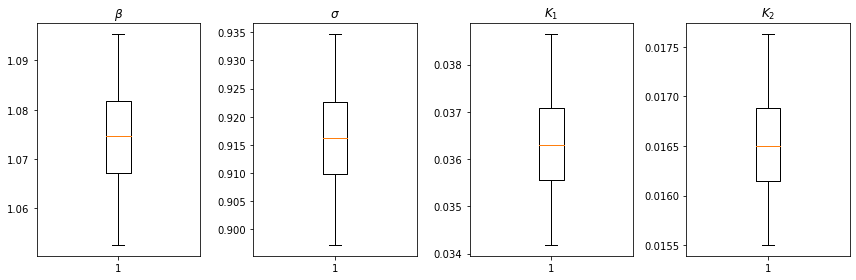

In [71]:
fig, axs = plt.subplots(1, 4,figsize=(12, 4))

axs[0].boxplot(vague_beta,whis=(2.5,97.5), sym='')
axs[0].set_title(r'$\beta$')

axs[1].boxplot(vague_sigma,whis=(2.5,97.5), sym='')
axs[1].set_title(r'$\sigma$')

axs[2].boxplot(vague_Karga1,whis=(2.5,97.5), sym='')
axs[2].set_title(r'$K_1$')

axs[3].boxplot(vague_Karga2,whis=(2.5,97.5), sym='')
axs[3].set_title(r'$K_2$')

plt.tight_layout()
plt.savefig(save_results_to+'Box_Params_JPN.pdf')

In [72]:
median_ppc = np.percentile(fit_dict['fake'],q=50.,axis=0)
CriL_ppc   = np.percentile(fit_dict['fake'],q=2.5,axis=0)
CriU_ppc   = np.percentile(fit_dict['fake'],q=97.5,axis=0)

In [75]:
def euclidean(v1, v2):
    return sum((q1-q2)**2 for q1, q2 in zip(v1, v2))**.5

print('Residuals of HIV cases =')
print(euclidean(median_ppc[:,0], y_obs[:,0]))
print('Residuals of AIDS cases =')
print(euclidean(median_ppc[:,1], y_obs[:,1]))
J_H_vague = (euclidean(median_ppc[:,0], y_obs[:,0]) + euclidean(median_ppc[:,1], y_obs[:,1])  )
print('J_H0_vague =')
print(J_H_vague)

Residuals of HIV cases =
571.9938810861529
Residuals of AIDS cases =
225.9336185697029
J_H0_vague =
797.9274996558559


In [95]:
Alpha = 2.
Beta  = 2.
beta_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 2.
Beta  = 2.
sigma_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 2.
Beta  = 2.
Karga1_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 2.
Beta  = 2.
Karga2_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)

In [96]:
# Fit
stan_code = """
functions {{
  real[] SIR(real t,  // time
  real[] y,           // system state {{susceptible,infected,recovered}}
  real[] theta,       // parameters
  real[] x_r,
  int[] x_i) {{
  
  real mu= 0.0077;
  real nu= 0.0098;



  real xi1     =  1e-4;
  real xi2     =  1e-6;
  real kappa  =  0.00003;
  
  real beta   = theta[1];
  real sigma  = theta[2];
  real Karga1 = theta[3];
  real Karga2 = theta[4];
  
  real dy_dt[3];
  
  dy_dt[1] =  mu -(beta*y[2] + nu + xi1  )*y[1];
  dy_dt[2]  =(beta* y[2] + xi1 ) *y[1] - (sigma + nu  - xi2)*y[2];
  dy_dt[3] = (sigma -xi2)* y[2] - (kappa + nu)*y[3];
  
  return dy_dt;
  }}
  
  }}
  data {{
  
    int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_small;       // number of days observed
  int<lower = 1> n_small_pred;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations
  int<lower = 1> n_pop;       // population 
  int y[n_obs,(n_difeq-1)];           // data, total number of infected individuals each day
  real t0;                // initial time point (zero)
  real ts[n_obs];         // time points observed
  real tsm[n_small];         // time points observed
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  real fake_ts[n_small_pred]; // Time points for "predicted"/"unsampled" data
  
  }}
  
  transformed data {{
  real x_r[0];
  int x_i[0];
  }}
  
  parameters {{

  real<lower =  0, upper = 1.5> beta ;
  real<lower =  0, upper = 1.> sigma ;
  real<lower =  0, upper = 3.> Karga1 ;
  real<lower =  0, upper = 3.> Karga2 ;


  
  }}
  
  transformed parameters{{
  
  real y_hat[n_obs,(n_difeq-1)]; // solution from the ODE solver
  real y_hat_sm[n_small, n_difeq]; // solution from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I
  real theta[n_theta];   // {{ alpha, beta, gamma, delta }}
  
  real S0;
  real I0;
  real A0;
  real lambda1[n_obs];
  real lambda2[n_obs];
  real rho1[n_obs]; 
  real rho2[n_obs];
  vector[11] weights;
  vector[11] incidence1;
  vector[11] incidence2;
  real dt=1./(10*n_obs);
  real xi1=1e-4;
  real xi2=1e-6;

  
  S0 = 0.999999952;
  I0 = 8e-9;
  A0 = 4e-8;
  

  y_init[1] = S0;
  y_init[2] = I0;
  y_init[3] = A0;
  
  
  theta[1] = beta;
  theta[2] = sigma;
  theta[3] = Karga1;
  theta[4] = Karga2;

  
  y_hat_sm = integrate_ode_rk45(SIR, y_init, t0, tsm, theta, x_r, x_i);

  
 weights[1]=0.5;
 weights[11]=0.5;
 
 for (i in 2:10){{
     weights[i] = 1.0;
  }}

 
  for (i in 1:n_obs){{
      lambda1[i] = 0.0;
      lambda2[i] = 0.0;
      for (k in 1:11){{
       incidence1[k] = (beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incidence2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];
       lambda1[i]    = lambda1[i] + dt*weights[k]*incidence1[k];
       lambda2[i]    = lambda2[i] + dt*weights[k]*incidence2[k];
      }}
  y_hat[i,1]=n_pop*Karga1*lambda1[i];
  y_hat[i,2]=n_pop*Karga2*lambda2[i];
 }}
    


  }}
  
  
  model {{
  
  real lamb1[n_obs];      //poisson parameter
  real lamb2[n_obs];      //poisson parameter
  real rhho1[n_obs];      //poisson parameter
  real rhho2[n_obs];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_obs);
  real xii1 =1e-4;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  //priors
  beta     ~ gamma(2, 2);
  sigma    ~ gamma(2, 2);
  Karga1   ~ gamma(2, 2);
  Karga2   ~ gamma(2, 2);
  
  
  //likelihood
  for (i in 1:(n_obs)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( beta*y_hat_sm[k + 10*(i-1),2] + xii1 )*y_hat_sm[k + 10*(i-1),1];
       incid2[k] = ( sigma- xii2 )*y_hat_sm[k + 10*(i-1),2];       
       lamb1[i]    = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]    = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i] = n_pop*Karga1*lamb1[i];
  rhho2[i] = n_pop*Karga2*lamb2[i]; 
  y[i , 1] ~ poisson(rhho1[i]);
  y[i , 2] ~ poisson(rhho2[i]);
  }}
 
  }}
  
  generated quantities {{
  real R_0;      // Basic reproduction number
  real nu= 0.0098;
//  real population=10649800;
  real epsilon = 1e-9;
  real fake[n_fake, 2];
  real <lower = 0.> y_hat_pred[n_small_pred, n_difeq]; // Output from the ODE solver
  
  real lamb1[n_fake];      //poisson parameter
  real lamb2[n_fake];      //poisson parameter
  real rhho1[n_fake];      //poisson parameter
  real rhho2[n_fake];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_fake);
  real xii1 =1e-5;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  y_hat_pred = integrate_ode_rk45(SIR, y_init, t0, fake_ts, theta, x_r, x_i);  
  
    //likelihood
  for (i in 1:(n_fake)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( theta[1]*y_hat_pred[k + 10*(i-1),2] + xii1 )*y_hat_pred[k + 10*(i-1),1];
       incid2[k] = ( theta[2]- xii2 )*y_hat_pred[k + 10*(i-1),2];       
       lamb1[i]   = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]   = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i]=n_pop*theta[3]*lamb1[i];
  rhho2[i]=n_pop*theta[4]*lamb2[i];
  fake[i , 1] = poisson_rng( rhho1[i] );
  fake[i , 2] = poisson_rng( rhho2[i] );
 
  }}
  
  
  R_0 = theta[1]/(theta[2] + nu);
  }}
""".format(
        beta   =beta_stan,
        sigma  =sigma_stan,
        Karga1 =Karga1_stan,
        Karga2 =Karga2_stan
        )

In [97]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c287621a5b1291514f7cd99518ac1f9 NOW.


--- 30.741923809051514 seconds ---


In [98]:
# do the fitting
start_time = time.time()
fit = sm.sampling(
                  data=mydata,
                  iter=NumIter,
                  chains=6,
                  warmup=burnin,
                  seed=431,
                  verbose=True,
                  algorithm='NUTS',
                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--- 248.59426832199097 seconds ---


In [99]:
varnames = ["beta", "sigma", "Karga1", "Karga2","R_0"]
summary=fit.summary(pars=varnames, probs=(0.025, 0.25, 0.5, 0.75, 0.975))

df_summary =  pd.DataFrame(
    summary['summary'],
    columns=summary['summary_colnames'],
    index=summary['summary_rownames']
)

fit_dict= fit.extract()
fit_df = fit.to_dataframe()


fit_dict= fit.extract()
fit_df = fit.to_dataframe()
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.073670,0.000127,0.011059,1.051663,1.066223,1.073831,1.081103,1.095287,7624.068512,1.000632
sigma,0.915687,0.000106,0.009610,0.896964,0.909149,0.915750,0.922092,0.934584,8176.486519,1.000525
Karga1,0.036451,0.000013,0.001139,0.034315,0.035658,0.036436,0.037197,0.038749,8232.269437,1.000574
Karga2,0.016572,0.000006,0.000545,0.015551,0.016195,0.016560,0.016930,0.017682,8125.797103,1.000557
R_0,1.160119,0.000033,0.003222,1.153808,1.157909,1.160103,1.162305,1.166484,9787.774852,1.000284


In [100]:
informative_beta   =fit_df['beta']
informative_sigma  =fit_df['sigma']
informative_Karga1 =fit_df['Karga1']
informative_Karga2 =fit_df['Karga2']

In [101]:
median_ppc = np.percentile(fit_dict['fake'],q=50.,axis=0)
CriL_ppc   = np.percentile(fit_dict['fake'],q=2.5,axis=0)
CriU_ppc   = np.percentile(fit_dict['fake'],q=97.5,axis=0)

In [102]:
def euclidean(v1, v2):
    return sum((q1-q2)**2 for q1, q2 in zip(v1, v2))**.5

print('Residuals of HIV cases =')
print(euclidean(median_ppc[:,0], y_obs[:,0]))
print('Residuals of AIDS cases =')
print(euclidean(median_ppc[:,1], y_obs[:,1]))
J_informative = (euclidean(median_ppc[:,0], y_obs[:,0]) + euclidean(median_ppc[:,1], y_obs[:,1])  )
print('J_informative =')
print(J_informative)

Residuals of HIV cases =
571.75956485222
Residuals of AIDS cases =
226.14818150938115
J_informative =
797.9077463616012


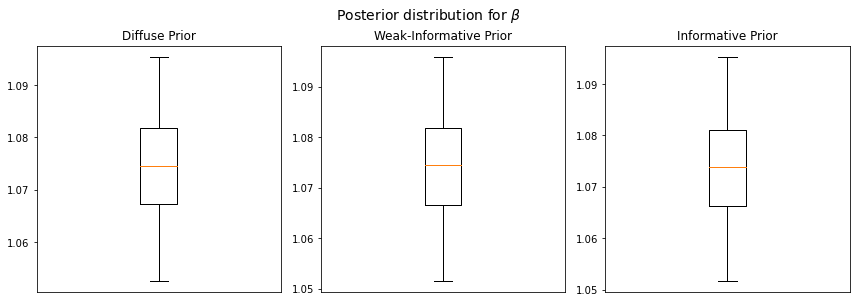

In [129]:
fig, axs = plt.subplots(1, 3,figsize=(12, 4))

axs[0].boxplot(vague_beta,whis=(2.5,97.5), sym='')
axs[0].set_title(r'Diffuse Prior')
axs[0].set_xticks([])

axs[1].boxplot(weakInform_beta,whis=(2.5,97.5), sym='')
axs[1].set_title(r'Weak-Informative Prior')
axs[1].set_xticks([])

axs[2].boxplot(informative_beta,whis=(2.5,97.5), sym='')
axs[2].set_title(r'Informative Prior')
axs[2].set_xticks([])

#plt.xticks([1], [""])
plt.tight_layout()
plt.suptitle(r'Posterior distribution for $\beta$', fontsize=14,va="bottom")
plt.savefig(save_results_to+'Posterior_beta_JPN.pdf')

In [ ]:
fig, axs = plt.subplots(1, 3,figsize=(12, 4))

axs[0].boxplot(vague_beta,whis=(2.5,97.5), sym='')
axs[0].set_title(r'Diffuse Prior')
axs[0].set_xticks([])

axs[1].boxplot(weakInform_beta,whis=(2.5,97.5), sym='')
axs[1].set_title(r'Weak-Informative Prior')
axs[1].set_xticks([])

axs[2].boxplot(informative_beta,whis=(2.5,97.5), sym='')
axs[2].set_title(r'Informative Prior')
axs[2].set_xticks([])

#plt.xticks([1], [""])
plt.tight_layout()
plt.suptitle(r'Posterior distribution for $\beta$', fontsize=14,va="bottom")
plt.savefig(save_results_to+'Posterior_beta_JPN.pdf')

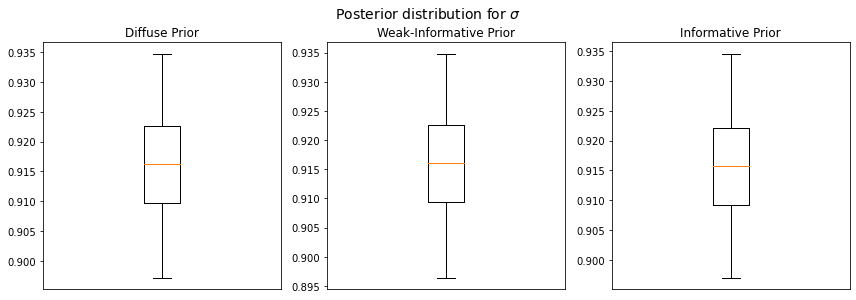

In [130]:
fig, axs = plt.subplots(1, 3,figsize=(12, 4))

axs[0].boxplot(vague_sigma,whis=(2.5,97.5), sym='')
axs[0].set_title(r'Diffuse Prior')
axs[0].set_xticks([])

axs[1].boxplot(weakInform_sigma,whis=(2.5,97.5), sym='')
axs[1].set_title(r'Weak-Informative Prior')
axs[1].set_xticks([])

axs[2].boxplot(informative_sigma,whis=(2.5,97.5), sym='')
axs[2].set_title(r'Informative Prior')
axs[2].set_xticks([])

plt.tight_layout()
plt.suptitle(r'Posterior distribution for $\sigma$', fontsize=14,va="bottom")
plt.savefig(save_results_to+'Posterior_sigma_JPN.pdf')

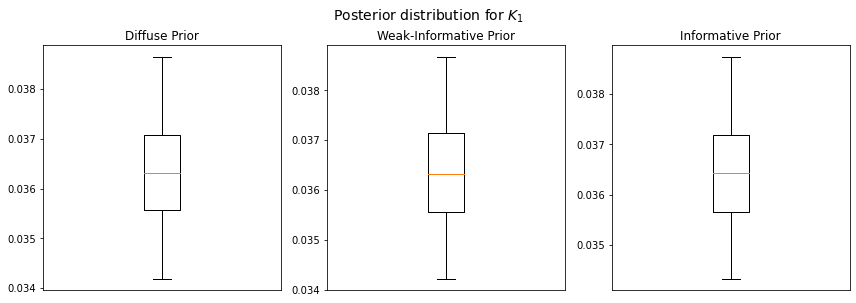

In [133]:
fig, axs = plt.subplots(1, 3,figsize=(12, 4))

axs[0].boxplot(vague_Karga1,whis=(2.5,97.5), sym='')
axs[0].set_title(r'Diffuse Prior')
axs[0].set_xticks([])

axs[1].boxplot(weakInform_Karga1,whis=(2.5,97.5), sym='')
axs[1].set_title(r'Weak-Informative Prior')
axs[1].set_xticks([])

axs[2].boxplot(informative_Karga1,whis=(2.5,97.5), sym='')
axs[2].set_title(r'Informative Prior')
axs[2].set_xticks([])

plt.tight_layout()
plt.suptitle(r'Posterior distribution for $K_1$', fontsize=14,va="bottom")
plt.savefig(save_results_to+'Posterior_Karga1_JPN.pdf')

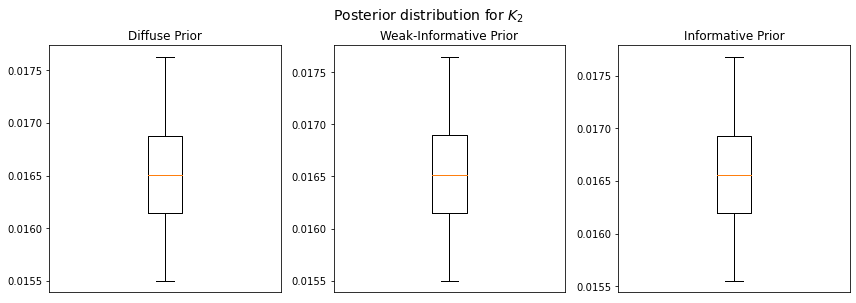

In [134]:
fig, axs = plt.subplots(1, 3,figsize=(12, 4))

axs[0].boxplot(vague_Karga2,whis=(2.5,97.5), sym='')
axs[0].set_title(r'Diffuse Prior')
axs[0].set_xticks([])

axs[1].boxplot(weakInform_Karga2,whis=(2.5,97.5), sym='')
axs[1].set_title(r'Weak-Informative Prior')
axs[1].set_xticks([])

axs[2].boxplot(informative_Karga2,whis=(2.5,97.5), sym='')
axs[2].set_title(r'Informative Prior')
axs[2].set_xticks([])

plt.tight_layout()
plt.suptitle(r'Posterior distribution for $K_2$', fontsize=14,va="bottom")
plt.savefig(save_results_to+'Posterior_Karga2_JPN.pdf')

In [135]:
beta_mu = 0.
beta_sd = 2.
beta_stan = 'uniform({mu}, {sigma})'.format(mu=beta_mu, sigma=beta_sd)


sigma_low  = 0
sigma_high = 1.5
sigma_stan = 'uniform({mu}, {sd})'.format(mu=sigma_low, sd=sigma_high)


Karga1_low  = 0
Karga1_high = 3
Karga1_stan = 'uniform({mu}, {sd})'.format(mu=Karga1_low, sd=Karga1_high)


Karga2_low  = 0
Karga2_high = 3
Karga2_stan = 'uniform({mu}, {sd})'.format(mu=Karga2_low, sd=Karga2_high)

In [136]:
# Fit
stan_code = """
functions {{
  real[] SIR(real t,  // time
  real[] y,           // system state {{susceptible,infected,recovered}}
  real[] theta,       // parameters
  real[] x_r,
  int[] x_i) {{
  
  real mu= 0.0077;
  real nu= 0.0098;



  real xi1     =  1e-4;
  real xi2     =  1e-6;
  real kappa  =  0.00003;
  
  real beta   = theta[1];
  real sigma  = theta[2];
  real Karga1 = theta[3];
  real Karga2 = theta[4];
  
  real dy_dt[3];
  
  dy_dt[1] =  mu -(beta*y[2] + nu + xi1  )*y[1];
  dy_dt[2]  =(beta* y[2] + xi1 ) *y[1] - (sigma + nu  - xi2)*y[2];
  dy_dt[3] = (sigma -xi2)* y[2] - (kappa + nu)*y[3];
  
  return dy_dt;
  }}
  
  }}
  data {{
  
    int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_small;       // number of days observed
  int<lower = 1> n_small_pred;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations
  int<lower = 1> n_pop;       // population 
  int y[n_obs,(n_difeq-1)];           // data, total number of infected individuals each day
  real t0;                // initial time point (zero)
  real ts[n_obs];         // time points observed
  real tsm[n_small];         // time points observed
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  real fake_ts[n_small_pred]; // Time points for "predicted"/"unsampled" data
  
  }}
  
  transformed data {{
  real x_r[0];
  int x_i[0];
  }}
  
  parameters {{

  real<lower =  0, upper = 2.> beta ;
  real<lower =  0, upper = 1.5> sigma ;
  real<lower =  0, upper = 3.> Karga1 ;
  real<lower =  0, upper = 3.> Karga2 ;


  
  }}
  
  transformed parameters{{
  
  real y_hat[n_obs,(n_difeq-1)]; // solution from the ODE solver
  real y_hat_sm[n_small, n_difeq]; // solution from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I
  real theta[n_theta];   // {{ alpha, beta, gamma, delta }}
  
  real S0;
  real I0;
  real A0;
  real lambda1[n_obs];
  real lambda2[n_obs];
  real rho1[n_obs]; 
  real rho2[n_obs];
  vector[11] weights;
  vector[11] incidence1;
  vector[11] incidence2;
  real dt=1./(10*n_obs);
  real xi1=1e-4;
  real xi2=1e-6;

  
  S0 = 0.999999952;
  I0 = 8e-9;
  A0 = 4e-8;
  

  y_init[1] = S0;
  y_init[2] = I0;
  y_init[3] = A0;
  
  
  theta[1] = beta;
  theta[2] = sigma;
  theta[3] = Karga1;
  theta[4] = Karga2;

  
  y_hat_sm = integrate_ode_rk45(SIR, y_init, t0, tsm, theta, x_r, x_i);

  
 weights[1]=0.5;
 weights[11]=0.5;
 
 for (i in 2:10){{
     weights[i] = 1.0;
  }}

 
  for (i in 1:n_obs){{
      lambda1[i] = 0.0;
      lambda2[i] = 0.0;
      for (k in 1:11){{
       incidence1[k] = (beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incidence2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];
       lambda1[i]    = lambda1[i] + dt*weights[k]*incidence1[k];
       lambda2[i]    = lambda2[i] + dt*weights[k]*incidence2[k];
      }}
  y_hat[i,1]=n_pop*Karga1*lambda1[i];
  y_hat[i,2]=n_pop*Karga2*lambda2[i];
 }}
    


  }}
  
  
  model {{
  
  real lamb1[n_obs];      //poisson parameter
  real lamb2[n_obs];      //poisson parameter
  real rhho1[n_obs];      //poisson parameter
  real rhho2[n_obs];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_obs);
  real xii1 =1e-4;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  //priors
  beta     ~ uniform(0, 2.);
  sigma    ~ uniform(0.0, 1.5 );
  Karga1   ~ uniform(0.0, 3 );
  Karga2   ~ uniform(0.0, 3);

  
  
  //likelihood
  for (i in 1:(n_obs)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( beta*y_hat_sm[k + 10*(i-1),2] + xii1 )*y_hat_sm[k + 10*(i-1),1];
       incid2[k] = ( sigma- xii2 )*y_hat_sm[k + 10*(i-1),2];       
       lamb1[i]    = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]    = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i] = n_pop*Karga1*lamb1[i];
  rhho2[i] = n_pop*Karga2*lamb2[i]; 
  y[i , 1] ~ poisson(rhho1[i]);
  y[i , 2] ~ poisson(rhho2[i]);
  }}
 
  }}
  
  generated quantities {{
  real R_0;      // Basic reproduction number
  real nu= 0.0098;
//  real population=10649800;
  real epsilon = 1e-9;
  real fake[n_fake, 2];
  real <lower = 0.> y_hat_pred[n_small_pred, n_difeq]; // Output from the ODE solver
  
  real lamb1[n_fake];      //poisson parameter
  real lamb2[n_fake];      //poisson parameter
  real rhho1[n_fake];      //poisson parameter
  real rhho2[n_fake];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_fake);
  real xii1 =1e-5;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  y_hat_pred = integrate_ode_rk45(SIR, y_init, t0, fake_ts, theta, x_r, x_i);  
  
    //likelihood
  for (i in 1:(n_fake)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( theta[1]*y_hat_pred[k + 10*(i-1),2] + xii1 )*y_hat_pred[k + 10*(i-1),1];
       incid2[k] = ( theta[2]- xii2 )*y_hat_pred[k + 10*(i-1),2];       
       lamb1[i]   = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]   = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i]=n_pop*theta[3]*lamb1[i];
  rhho2[i]=n_pop*theta[4]*lamb2[i];
  fake[i , 1] = poisson_rng( rhho1[i] );
  fake[i , 2] = poisson_rng( rhho2[i] );
 
  }}
  
  
  R_0 = theta[1]/(theta[2] + nu);
  }}
""".format(
        beta   =beta_stan,
        sigma  =sigma_stan,
        Karga1 =Karga1_stan,
        Karga2 =Karga2_stan
        )

In [137]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8af9f1176f9a7e49c9413dd700ed9d88 NOW.


--- 30.860948085784912 seconds ---


In [138]:
# do the fitting
start_time = time.time()
fit = sm.sampling(
                  data=mydata,
                  iter=NumIter,
                  chains=6,
                  warmup=burnin,
                  seed=431,
                  verbose=True,
                  algorithm='NUTS',
                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--- 251.51294207572937 seconds ---


In [139]:
varnames = ["beta", "sigma", "Karga1", "Karga2","R_0"]
summary=fit.summary(pars=varnames, probs=(0.025, 0.25, 0.5, 0.75, 0.975))

df_summary =  pd.DataFrame(
    summary['summary'],
    columns=summary['summary_colnames'],
    index=summary['summary_rownames']
)

fit_dict= fit.extract()
fit_df = fit.to_dataframe()


fit_dict= fit.extract()
fit_df = fit.to_dataframe()
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.074214,0.000131,0.011178,1.051427,1.066944,1.074295,1.081757,1.096024,7310.672118,1.001231
sigma,0.916009,0.000108,0.009685,0.896747,0.909540,0.916041,0.922558,0.934876,8011.972600,1.000980
Karga1,0.036370,0.000012,0.001149,0.034159,0.035595,0.036350,0.037138,0.038655,9068.545892,1.000723
Karga2,0.016534,0.000006,0.000550,0.015475,0.016162,0.016523,0.016896,0.017633,8958.230004,1.000940
R_0,1.160303,0.000032,0.003248,1.154116,1.158060,1.160259,1.162462,1.166811,10600.827848,1.000288


In [140]:
median_ppc = np.percentile(fit_dict['fake'],q=50.,axis=0)
CriL_ppc   = np.percentile(fit_dict['fake'],q=2.5,axis=0)
CriU_ppc   = np.percentile(fit_dict['fake'],q=97.5,axis=0)

In [141]:
def euclidean(v1, v2):
    return sum((q1-q2)**2 for q1, q2 in zip(v1, v2))**.5

print('Residuals of HIV cases =')
print(euclidean(median_ppc[:,0], y_obs[:,0]))
print('Residuals of AIDS cases =')
print(euclidean(median_ppc[:,1], y_obs[:,1]))
J_unif1 = (euclidean(median_ppc[:,0], y_obs[:,0]) + euclidean(median_ppc[:,1], y_obs[:,1])  )
print('J_unif1 =')
print(J_unif1)

Residuals of HIV cases =
571.9938810861529
Residuals of AIDS cases =
225.7808672142084
J_unif1 =
797.7747483003614


In [142]:
Alpha = 3.
Beta  = 1.
beta_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 3.
Beta  = 1.
sigma_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 3.
Beta  = 1.
Karga1_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 3.
Beta  = 1.
Karga2_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)

In [143]:
# Fit
stan_code = """
functions {{
  real[] SIR(real t,  // time
  real[] y,           // system state {{susceptible,infected,recovered}}
  real[] theta,       // parameters
  real[] x_r,
  int[] x_i) {{
  
  real mu= 0.0077;
  real nu= 0.0098;



  real xi1     =  1e-4;
  real xi2     =  1e-6;
  real kappa  =  0.00003;
  
  real beta   = theta[1];
  real sigma  = theta[2];
  real Karga1 = theta[3];
  real Karga2 = theta[4];
  
  real dy_dt[3];
  
  dy_dt[1] =  mu -(beta*y[2] + nu + xi1  )*y[1];
  dy_dt[2]  =(beta* y[2] + xi1 ) *y[1] - (sigma + nu  - xi2)*y[2];
  dy_dt[3] = (sigma -xi2)* y[2] - (kappa + nu)*y[3];
  
  return dy_dt;
  }}
  
  }}
  data {{
  
    int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_small;       // number of days observed
  int<lower = 1> n_small_pred;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations
  int<lower = 1> n_pop;       // population 
  int y[n_obs,(n_difeq-1)];           // data, total number of infected individuals each day
  real t0;                // initial time point (zero)
  real ts[n_obs];         // time points observed
  real tsm[n_small];         // time points observed
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  real fake_ts[n_small_pred]; // Time points for "predicted"/"unsampled" data
  
  }}
  
  transformed data {{
  real x_r[0];
  int x_i[0];
  }}
  
  parameters {{

  real<lower =  0, upper = 1.5> beta ;
  real<lower =  0, upper = 1.> sigma ;
  real<lower =  0, upper = 3.> Karga1 ;
  real<lower =  0, upper = 3.> Karga2 ;


  
  }}
  
  transformed parameters{{
  
  real y_hat[n_obs,(n_difeq-1)]; // solution from the ODE solver
  real y_hat_sm[n_small, n_difeq]; // solution from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I
  real theta[n_theta];   // {{ alpha, beta, gamma, delta }}
  
  real S0;
  real I0;
  real A0;
  real lambda1[n_obs];
  real lambda2[n_obs];
  real rho1[n_obs]; 
  real rho2[n_obs];
  vector[11] weights;
  vector[11] incidence1;
  vector[11] incidence2;
  real dt=1./(10*n_obs);
  real xi1=1e-4;
  real xi2=1e-6;

  
  S0 = 0.999999952;
  I0 = 8e-9;
  A0 = 4e-8;
  

  y_init[1] = S0;
  y_init[2] = I0;
  y_init[3] = A0;
  
  
  theta[1] = beta;
  theta[2] = sigma;
  theta[3] = Karga1;
  theta[4] = Karga2;

  
  y_hat_sm = integrate_ode_rk45(SIR, y_init, t0, tsm, theta, x_r, x_i);

  
 weights[1]=0.5;
 weights[11]=0.5;
 
 for (i in 2:10){{
     weights[i] = 1.0;
  }}

 
  for (i in 1:n_obs){{
      lambda1[i] = 0.0;
      lambda2[i] = 0.0;
      for (k in 1:11){{
       incidence1[k] = (beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incidence2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];
       lambda1[i]    = lambda1[i] + dt*weights[k]*incidence1[k];
       lambda2[i]    = lambda2[i] + dt*weights[k]*incidence2[k];
      }}
  y_hat[i,1]=n_pop*Karga1*lambda1[i];
  y_hat[i,2]=n_pop*Karga2*lambda2[i];
 }}
    


  }}
  
  
  model {{
  
  real lamb1[n_obs];      //poisson parameter
  real lamb2[n_obs];      //poisson parameter
  real rhho1[n_obs];      //poisson parameter
  real rhho2[n_obs];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_obs);
  real xii1 =1e-4;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  //priors
  beta     ~ gamma(3, 1);
  sigma    ~ gamma(3, 1);
  Karga1   ~ gamma(3, 1);
  Karga2   ~ gamma(3, 1);
  
  
  //likelihood
  for (i in 1:(n_obs)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( beta*y_hat_sm[k + 10*(i-1),2] + xii1 )*y_hat_sm[k + 10*(i-1),1];
       incid2[k] = ( sigma- xii2 )*y_hat_sm[k + 10*(i-1),2];       
       lamb1[i]    = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]    = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i] = n_pop*Karga1*lamb1[i];
  rhho2[i] = n_pop*Karga2*lamb2[i]; 
  y[i , 1] ~ poisson(rhho1[i]);
  y[i , 2] ~ poisson(rhho2[i]);
  }}
 
  }}
  
  generated quantities {{
  real R_0;      // Basic reproduction number
  real nu= 0.0098;
//  real population=10649800;
  real epsilon = 1e-9;
  real fake[n_fake, 2];
  real <lower = 0.> y_hat_pred[n_small_pred, n_difeq]; // Output from the ODE solver
  
  real lamb1[n_fake];      //poisson parameter
  real lamb2[n_fake];      //poisson parameter
  real rhho1[n_fake];      //poisson parameter
  real rhho2[n_fake];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_fake);
  real xii1 =1e-5;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  y_hat_pred = integrate_ode_rk45(SIR, y_init, t0, fake_ts, theta, x_r, x_i);  
  
    //likelihood
  for (i in 1:(n_fake)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( theta[1]*y_hat_pred[k + 10*(i-1),2] + xii1 )*y_hat_pred[k + 10*(i-1),1];
       incid2[k] = ( theta[2]- xii2 )*y_hat_pred[k + 10*(i-1),2];       
       lamb1[i]   = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]   = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i]=n_pop*theta[3]*lamb1[i];
  rhho2[i]=n_pop*theta[4]*lamb2[i];
  fake[i , 1] = poisson_rng( rhho1[i] );
  fake[i , 2] = poisson_rng( rhho2[i] );
 
  }}
  
  
  R_0 = theta[1]/(theta[2] + nu);
  }}
""".format(
        beta   =beta_stan,
        sigma  =sigma_stan,
        Karga1 =Karga1_stan,
        Karga2 =Karga2_stan
        )

In [144]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3904fb8f592424963dcaaa6debd5f904 NOW.


--- 31.94732642173767 seconds ---


In [145]:
# do the fitting
start_time = time.time()
fit = sm.sampling(
                  data=mydata,
                  iter=NumIter,
                  chains=6,
                  warmup=burnin,
                  seed=431,
                  verbose=True,
                  algorithm='NUTS',
                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--- 242.95217442512512 seconds ---


In [146]:
varnames = ["beta", "sigma", "Karga1", "Karga2","R_0"]
summary=fit.summary(pars=varnames, probs=(0.025, 0.25, 0.5, 0.75, 0.975))

df_summary =  pd.DataFrame(
    summary['summary'],
    columns=summary['summary_colnames'],
    index=summary['summary_rownames']
)

fit_dict= fit.extract()
fit_df = fit.to_dataframe()


fit_dict= fit.extract()
fit_df = fit.to_dataframe()
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.073864,0.000127,0.011247,1.051351,1.066394,1.073987,1.081470,1.095554,7896.933575,1.000725
sigma,0.915972,0.000106,0.009788,0.896581,0.909482,0.916028,0.922551,0.935107,8569.262189,1.000665
Karga1,0.036487,0.000012,0.001159,0.034313,0.035676,0.036466,0.037255,0.038845,8702.918050,1.000628
Karga2,0.016589,0.000006,0.000552,0.015552,0.016203,0.016579,0.016956,0.017692,8711.257155,1.000518
R_0,1.159973,0.000032,0.003272,1.153577,1.157756,1.159953,1.162193,1.166409,10515.680136,1.000353


In [147]:
median_ppc = np.percentile(fit_dict['fake'],q=50.,axis=0)
CriL_ppc   = np.percentile(fit_dict['fake'],q=2.5,axis=0)
CriU_ppc   = np.percentile(fit_dict['fake'],q=97.5,axis=0)

In [149]:
def euclidean(v1, v2):
    return sum((q1-q2)**2 for q1, q2 in zip(v1, v2))**.5

print('Residuals of HIV cases =')
print(euclidean(median_ppc[:,0], y_obs[:,0]))
print('Residuals of AIDS cases =')
print(euclidean(median_ppc[:,1], y_obs[:,1]))
J_gamma2 = (euclidean(median_ppc[:,0], y_obs[:,0]) + euclidean(median_ppc[:,1], y_obs[:,1])  )
print('J_gamma2 =')
print(J_gamma2)

Residuals of HIV cases =
571.9492984522317
Residuals of AIDS cases =
225.76370390299678
J_gamma2 =
797.7130023552285


In [15]:
Alpha = 1.
Beta  = 3.
beta_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 1.
Beta  = 3.
sigma_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 1.
Beta  = 3.
Karga1_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)


Alpha = 1.
Beta  = 3.
Karga2_stan = 'gamma({alpha}, {beta})'.format(alpha=Alpha, beta=Beta)

In [16]:
# Fit
stan_code = """
functions {{
  real[] SIR(real t,  // time
  real[] y,           // system state {{susceptible,infected,recovered}}
  real[] theta,       // parameters
  real[] x_r,
  int[] x_i) {{
  
  real mu= 0.0077;
  real nu= 0.0098;



  real xi1     =  1e-4;
  real xi2     =  1e-6;
  real kappa  =  0.00003;
  
  real beta   = theta[1];
  real sigma  = theta[2];
  real Karga1 = theta[3];
  real Karga2 = theta[4];
  
  real dy_dt[3];
  
  dy_dt[1] =  mu -(beta*y[2] + nu + xi1  )*y[1];
  dy_dt[2]  =(beta* y[2] + xi1 ) *y[1] - (sigma + nu  - xi2)*y[2];
  dy_dt[3] = (sigma -xi2)* y[2] - (kappa + nu)*y[3];
  
  return dy_dt;
  }}
  
  }}
  data {{
  
    int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_small;       // number of days observed
  int<lower = 1> n_small_pred;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations
  int<lower = 1> n_pop;       // population 
  int y[n_obs,(n_difeq-1)];           // data, total number of infected individuals each day
  real t0;                // initial time point (zero)
  real ts[n_obs];         // time points observed
  real tsm[n_small];         // time points observed
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  real fake_ts[n_small_pred]; // Time points for "predicted"/"unsampled" data
  
  }}
  
  transformed data {{
  real x_r[0];
  int x_i[0];
  }}
  
  parameters {{

  real<lower =  0, upper = 1.5> beta ;
  real<lower =  0, upper = 1.> sigma ;
  real<lower =  0, upper = 3.> Karga1 ;
  real<lower =  0, upper = 3.> Karga2 ;


  
  }}
  
  transformed parameters{{
  
  real y_hat[n_obs,(n_difeq-1)]; // solution from the ODE solver
  real y_hat_sm[n_small, n_difeq]; // solution from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I
  real theta[n_theta];   // {{ alpha, beta, gamma, delta }}
  
  real S0;
  real I0;
  real A0;
  real lambda1[n_obs];
  real lambda2[n_obs];
  real rho1[n_obs]; 
  real rho2[n_obs];
  vector[11] weights;
  vector[11] incidence1;
  vector[11] incidence2;
  real dt=1./(10*n_obs);
  real xi1=1e-4;
  real xi2=1e-6;

  
  S0 = 0.999999952;
  I0 = 8e-9;
  A0 = 4e-8;
  

  y_init[1] = S0;
  y_init[2] = I0;
  y_init[3] = A0;
  
  
  theta[1] = beta;
  theta[2] = sigma;
  theta[3] = Karga1;
  theta[4] = Karga2;

  
  y_hat_sm = integrate_ode_rk45(SIR, y_init, t0, tsm, theta, x_r, x_i);

  
 weights[1]=0.5;
 weights[11]=0.5;
 
 for (i in 2:10){{
     weights[i] = 1.0;
  }}

 
  for (i in 1:n_obs){{
      lambda1[i] = 0.0;
      lambda2[i] = 0.0;
      for (k in 1:11){{
       incidence1[k] = (beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incidence2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];
       lambda1[i]    = lambda1[i] + dt*weights[k]*incidence1[k];
       lambda2[i]    = lambda2[i] + dt*weights[k]*incidence2[k];
      }}
  y_hat[i,1]=n_pop*Karga1*lambda1[i];
  y_hat[i,2]=n_pop*Karga2*lambda2[i];
 }}
    


  }}
  
  
  model {{
  
  real lamb1[n_obs];      //poisson parameter
  real lamb2[n_obs];      //poisson parameter
  real rhho1[n_obs];      //poisson parameter
  real rhho2[n_obs];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_obs);
  real xii1 =1e-4;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  //priors
  beta     ~ gamma(1, 3);
  sigma    ~ gamma(1, 3);
  Karga1   ~ gamma(1, 3);
  Karga2   ~ gamma(1, 3);
  
  
  //likelihood
  for (i in 1:(n_obs)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( beta*y_hat_sm[k + 10*(i-1),2] + xii1 )*y_hat_sm[k + 10*(i-1),1];
       incid2[k] = ( sigma- xii2 )*y_hat_sm[k + 10*(i-1),2];       
       lamb1[i]    = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]    = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i] = n_pop*Karga1*lamb1[i];
  rhho2[i] = n_pop*Karga2*lamb2[i]; 
  y[i , 1] ~ poisson(rhho1[i]);
  y[i , 2] ~ poisson(rhho2[i]);
  }}
 
  }}
  
  generated quantities {{
  real R_0;      // Basic reproduction number
  real nu= 0.0098;
//  real population=10649800;
  real epsilon = 1e-9;
  real fake[n_fake, 2];
  real <lower = 0.> y_hat_pred[n_small_pred, n_difeq]; // Output from the ODE solver
  
  real lamb1[n_fake];      //poisson parameter
  real lamb2[n_fake];      //poisson parameter
  real rhho1[n_fake];      //poisson parameter
  real rhho2[n_fake];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_fake);
  real xii1 =1e-5;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  y_hat_pred = integrate_ode_rk45(SIR, y_init, t0, fake_ts, theta, x_r, x_i);  
  
    //likelihood
  for (i in 1:(n_fake)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( theta[1]*y_hat_pred[k + 10*(i-1),2] + xii1 )*y_hat_pred[k + 10*(i-1),1];
       incid2[k] = ( theta[2]- xii2 )*y_hat_pred[k + 10*(i-1),2];       
       lamb1[i]   = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]   = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i]=n_pop*theta[3]*lamb1[i];
  rhho2[i]=n_pop*theta[4]*lamb2[i];
  fake[i , 1] = poisson_rng( rhho1[i] );
  fake[i , 2] = poisson_rng( rhho2[i] );
 
  }}
  
  
  R_0 = theta[1]/(theta[2] + nu);
  }}
""".format(
        beta   =beta_stan,
        sigma  =sigma_stan,
        Karga1 =Karga1_stan,
        Karga2 =Karga2_stan
        )

In [17]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9e640f13e978d42e2682d0793c1a8f6e NOW.


--- 30.255164623260498 seconds ---


In [18]:
# do the fitting
start_time = time.time()
fit = sm.sampling(
                  data=mydata,
                  iter=NumIter,
                  chains=6,
                  warmup=burnin,
                  seed=431,
                  verbose=True,
                  algorithm='NUTS',
                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--- 252.684321641922 seconds ---


In [19]:
varnames = ["beta", "sigma", "Karga1", "Karga2","R_0"]
summary=fit.summary(pars=varnames, probs=(0.025, 0.25, 0.5, 0.75, 0.975))

df_summary =  pd.DataFrame(
    summary['summary'],
    columns=summary['summary_colnames'],
    index=summary['summary_rownames']
)

fit_dict= fit.extract()
fit_df = fit.to_dataframe()


fit_dict= fit.extract()
fit_df = fit.to_dataframe()
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.073640,0.000125,0.011005,1.050991,1.066293,1.073952,1.081142,1.094612,7698.753336,1.001070
sigma,0.915446,0.000104,0.009553,0.896329,0.909083,0.915622,0.921894,0.933778,8370.450742,1.001269
Karga1,0.036370,0.000012,0.001151,0.034230,0.035566,0.036334,0.037126,0.038711,8696.185970,1.000036
Karga2,0.016535,0.000006,0.000550,0.015513,0.016155,0.016518,0.016897,0.017662,8525.206330,1.000107
R_0,1.160389,0.000032,0.003269,1.154047,1.158194,1.160375,1.162578,1.166908,10655.613806,1.000187


In [20]:
median_ppc = np.percentile(fit_dict['fake'],q=50.,axis=0)
CriL_ppc   = np.percentile(fit_dict['fake'],q=2.5,axis=0)
CriU_ppc   = np.percentile(fit_dict['fake'],q=97.5,axis=0)

In [21]:
def euclidean(v1, v2):
    return sum((q1-q2)**2 for q1, q2 in zip(v1, v2))**.5

print('Residuals of HIV cases =')
print(euclidean(median_ppc[:,0], y_obs[:,0]))
print('Residuals of AIDS cases =')
print(euclidean(median_ppc[:,1], y_obs[:,1]))
J_gamma3 = (euclidean(median_ppc[:,0], y_obs[:,0]) + euclidean(median_ppc[:,1], y_obs[:,1])  )
print('J_gamma3 =')
print(J_gamma3)

Residuals of HIV cases =
571.7875479581555
Residuals of AIDS cases =
225.95132219130738
J_gamma3 =
797.7388701494629


In [22]:
beta_mu = 0.
beta_sd = 1.5
beta_stan = 'uniform({mu}, {sigma})'.format(mu=beta_mu, sigma=beta_sd)


sigma_low  = 0
sigma_high = 1
sigma_stan = 'uniform({mu}, {sd})'.format(mu=sigma_low, sd=sigma_high)


Karga1_low  = 0
Karga1_high = 1
Karga1_stan = 'uniform({mu}, {sd})'.format(mu=Karga1_low, sd=Karga1_high)


Karga2_low  = 0
Karga2_high = 1
Karga2_stan = 'uniform({mu}, {sd})'.format(mu=Karga2_low, sd=Karga2_high)

In [23]:
# Fit
stan_code = """
functions {{
  real[] SIR(real t,  // time
  real[] y,           // system state {{susceptible,infected,recovered}}
  real[] theta,       // parameters
  real[] x_r,
  int[] x_i) {{
  
  real mu= 0.0077;
  real nu= 0.0098;



  real xi1     =  1e-4;
  real xi2     =  1e-6;
  real kappa  =  0.00003;
  
  real beta   = theta[1];
  real sigma  = theta[2];
  real Karga1 = theta[3];
  real Karga2 = theta[4];
  
  real dy_dt[3];
  
  dy_dt[1] =  mu -(beta*y[2] + nu + xi1  )*y[1];
  dy_dt[2]  =(beta* y[2] + xi1 ) *y[1] - (sigma + nu  - xi2)*y[2];
  dy_dt[3] = (sigma -xi2)* y[2] - (kappa + nu)*y[3];
  
  return dy_dt;
  }}
  
  }}
  data {{
  
    int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_small;       // number of days observed
  int<lower = 1> n_small_pred;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations
  int<lower = 1> n_pop;       // population 
  int y[n_obs,(n_difeq-1)];           // data, total number of infected individuals each day
  real t0;                // initial time point (zero)
  real ts[n_obs];         // time points observed
  real tsm[n_small];         // time points observed
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  real fake_ts[n_small_pred]; // Time points for "predicted"/"unsampled" data
  
  }}
  
  transformed data {{
  real x_r[0];
  int x_i[0];
  }}
  
  parameters {{

  real<lower =  0, upper = 1.5> beta ;
  real<lower =  0, upper = 1.> sigma ;
  real<lower =  0, upper = 1.> Karga1 ;
  real<lower =  0, upper = 1.> Karga2 ;


  
  }}
  
  transformed parameters{{
  
  real y_hat[n_obs,(n_difeq-1)]; // solution from the ODE solver
  real y_hat_sm[n_small, n_difeq]; // solution from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I
  real theta[n_theta];   // {{ alpha, beta, gamma, delta }}
  
  real S0;
  real I0;
  real A0;
  real lambda1[n_obs];
  real lambda2[n_obs];
  real rho1[n_obs]; 
  real rho2[n_obs];
  vector[11] weights;
  vector[11] incidence1;
  vector[11] incidence2;
  real dt=1./(10*n_obs);
  real xi1=1e-4;
  real xi2=1e-6;

  
  S0 = 0.999999952;
  I0 = 8e-9;
  A0 = 4e-8;
  

  y_init[1] = S0;
  y_init[2] = I0;
  y_init[3] = A0;
  
  
  theta[1] = beta;
  theta[2] = sigma;
  theta[3] = Karga1;
  theta[4] = Karga2;

  
  y_hat_sm = integrate_ode_rk45(SIR, y_init, t0, tsm, theta, x_r, x_i);

  
 weights[1]=0.5;
 weights[11]=0.5;
 
 for (i in 2:10){{
     weights[i] = 1.0;
  }}

 
  for (i in 1:n_obs){{
      lambda1[i] = 0.0;
      lambda2[i] = 0.0;
      for (k in 1:11){{
       incidence1[k] = (beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incidence2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];
       lambda1[i]    = lambda1[i] + dt*weights[k]*incidence1[k];
       lambda2[i]    = lambda2[i] + dt*weights[k]*incidence2[k];
      }}
  y_hat[i,1]=n_pop*Karga1*lambda1[i];
  y_hat[i,2]=n_pop*Karga2*lambda2[i];
 }}
    


  }}
  
  
  model {{
  
  real lamb1[n_obs];      //poisson parameter
  real lamb2[n_obs];      //poisson parameter
  real rhho1[n_obs];      //poisson parameter
  real rhho2[n_obs];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_obs);
  real xii1 =1e-4;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  //priors
  beta     ~ uniform(0, 1.5);
  sigma    ~ uniform(0.0, 1. );
  Karga1   ~ uniform(0.0, 1 );
  Karga2   ~ uniform(0.0, 1);

  
  
  //likelihood
  for (i in 1:(n_obs)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( beta*y_hat_sm[k + 10*(i-1),2] + xii1 )*y_hat_sm[k + 10*(i-1),1];
       incid2[k] = ( sigma- xii2 )*y_hat_sm[k + 10*(i-1),2];       
       lamb1[i]    = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]    = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i] = n_pop*Karga1*lamb1[i];
  rhho2[i] = n_pop*Karga2*lamb2[i]; 
  y[i , 1] ~ poisson(rhho1[i]);
  y[i , 2] ~ poisson(rhho2[i]);
  }}
 
  }}
  
  generated quantities {{
  real R_0;      // Basic reproduction number
  real nu= 0.0098;
//  real population=10649800;
  real epsilon = 1e-9;
  real fake[n_fake, 2];
  real <lower = 0.> y_hat_pred[n_small_pred, n_difeq]; // Output from the ODE solver
  
  real lamb1[n_fake];      //poisson parameter
  real lamb2[n_fake];      //poisson parameter
  real rhho1[n_fake];      //poisson parameter
  real rhho2[n_fake];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_fake);
  real xii1 =1e-5;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  y_hat_pred = integrate_ode_rk45(SIR, y_init, t0, fake_ts, theta, x_r, x_i);  
  
    //likelihood
  for (i in 1:(n_fake)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( theta[1]*y_hat_pred[k + 10*(i-1),2] + xii1 )*y_hat_pred[k + 10*(i-1),1];
       incid2[k] = ( theta[2]- xii2 )*y_hat_pred[k + 10*(i-1),2];       
       lamb1[i]   = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]   = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i]=n_pop*theta[3]*lamb1[i];
  rhho2[i]=n_pop*theta[4]*lamb2[i];
  fake[i , 1] = poisson_rng( rhho1[i] );
  fake[i , 2] = poisson_rng( rhho2[i] );
 
  }}
  
  
  R_0 = theta[1]/(theta[2] + nu);
  }}
""".format(
        beta   =beta_stan,
        sigma  =sigma_stan,
        Karga1 =Karga1_stan,
        Karga2 =Karga2_stan
        )

In [24]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7ff69a558d14f267590b6d9dc39e7bde NOW.


--- 31.1802499294281 seconds ---


In [25]:
# do the fitting
start_time = time.time()
fit = sm.sampling(
                  data=mydata,
                  iter=NumIter,
                  chains=6,
                  warmup=burnin,
                  seed=431,
                  verbose=True,
                  algorithm='NUTS',
                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--- 419.6173143386841 seconds ---


In [26]:
varnames = ["beta", "sigma", "Karga1", "Karga2","R_0"]
summary=fit.summary(pars=varnames, probs=(0.025, 0.25, 0.5, 0.75, 0.975))

df_summary =  pd.DataFrame(
    summary['summary'],
    columns=summary['summary_colnames'],
    index=summary['summary_rownames']
)

fit_dict= fit.extract()
fit_df = fit.to_dataframe()


fit_dict= fit.extract()
fit_df = fit.to_dataframe()
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.074164,0.000128,0.011008,1.052010,1.066823,1.074321,1.081688,1.095268,7338.680846,1.000385
sigma,0.915922,0.000106,0.009539,0.896943,0.909551,0.915962,0.922341,0.934467,8022.968881,1.000394
Karga1,0.036355,0.000012,0.001147,0.034203,0.035566,0.036325,0.037116,0.038693,8554.946335,1.000363
Karga2,0.016527,0.000006,0.000549,0.015490,0.016150,0.016513,0.016893,0.017643,8326.241066,1.000406
R_0,1.160359,0.000032,0.003254,1.154118,1.158145,1.160309,1.162522,1.166881,10420.325629,1.000414


In [27]:
median_ppc = np.percentile(fit_dict['fake'],q=50.,axis=0)
CriL_ppc   = np.percentile(fit_dict['fake'],q=2.5,axis=0)
CriU_ppc   = np.percentile(fit_dict['fake'],q=97.5,axis=0)

In [28]:
def euclidean(v1, v2):
    return sum((q1-q2)**2 for q1, q2 in zip(v1, v2))**.5

print('Residuals of HIV cases =')
print(euclidean(median_ppc[:,0], y_obs[:,0]))
print('Residuals of AIDS cases =')
print(euclidean(median_ppc[:,1], y_obs[:,1]))
J_uniform2 = (euclidean(median_ppc[:,0], y_obs[:,0]) + euclidean(median_ppc[:,1], y_obs[:,1])  )
print('J_uniform2 =')
print(J_uniform2)

Residuals of HIV cases =
571.8225249148551
Residuals of AIDS cases =
226.14375958668415
J_uniform2 =
797.9662845015392


In [29]:
beta_mu = 0.
beta_sd = 2.
beta_stan = 'uniform({mu}, {sigma})'.format(mu=beta_mu, sigma=beta_sd)


sigma_low  = 0
sigma_high = 1
sigma_stan = 'uniform({mu}, {sd})'.format(mu=sigma_low, sd=sigma_high)


Karga1_low  = 0
Karga1_high = 3
Karga1_stan = 'uniform({mu}, {sd})'.format(mu=Karga1_low, sd=Karga1_high)


Karga2_low  = 0
Karga2_high = 1
Karga2_stan = 'uniform({mu}, {sd})'.format(mu=Karga2_low, sd=Karga2_high)

In [30]:
# Fit
stan_code = """
functions {{
  real[] SIR(real t,  // time
  real[] y,           // system state {{susceptible,infected,recovered}}
  real[] theta,       // parameters
  real[] x_r,
  int[] x_i) {{
  
  real mu= 0.0077;
  real nu= 0.0098;



  real xi1     =  1e-4;
  real xi2     =  1e-6;
  real kappa  =  0.00003;
  
  real beta   = theta[1];
  real sigma  = theta[2];
  real Karga1 = theta[3];
  real Karga2 = theta[4];
  
  real dy_dt[3];
  
  dy_dt[1] =  mu -(beta*y[2] + nu + xi1  )*y[1];
  dy_dt[2]  =(beta* y[2] + xi1 ) *y[1] - (sigma + nu  - xi2)*y[2];
  dy_dt[3] = (sigma -xi2)* y[2] - (kappa + nu)*y[3];
  
  return dy_dt;
  }}
  
  }}
  data {{
  
    int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_small;       // number of days observed
  int<lower = 1> n_small_pred;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations
  int<lower = 1> n_pop;       // population 
  int y[n_obs,(n_difeq-1)];           // data, total number of infected individuals each day
  real t0;                // initial time point (zero)
  real ts[n_obs];         // time points observed
  real tsm[n_small];         // time points observed
  int<lower = 1> n_fake; // This is to generate "predicted"/"unsampled" data
  real fake_ts[n_small_pred]; // Time points for "predicted"/"unsampled" data
  
  }}
  
  transformed data {{
  real x_r[0];
  int x_i[0];
  }}
  
  parameters {{

  real<lower =  0, upper = 2.> beta ;
  real<lower =  0, upper = 1.> sigma ;
  real<lower =  0, upper = 3.> Karga1 ;
  real<lower =  0, upper = 1.> Karga2 ;


  
  }}
  
  transformed parameters{{
  
  real y_hat[n_obs,(n_difeq-1)]; // solution from the ODE solver
  real y_hat_sm[n_small, n_difeq]; // solution from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I
  real theta[n_theta];   // {{ alpha, beta, gamma, delta }}
  
  real S0;
  real I0;
  real A0;
  real lambda1[n_obs];
  real lambda2[n_obs];
  real rho1[n_obs]; 
  real rho2[n_obs];
  vector[11] weights;
  vector[11] incidence1;
  vector[11] incidence2;
  real dt=1./(10*n_obs);
  real xi1=1e-4;
  real xi2=1e-6;

  
  S0 = 0.999999952;
  I0 = 8e-9;
  A0 = 4e-8;
  

  y_init[1] = S0;
  y_init[2] = I0;
  y_init[3] = A0;
  
  
  theta[1] = beta;
  theta[2] = sigma;
  theta[3] = Karga1;
  theta[4] = Karga2;

  
  y_hat_sm = integrate_ode_rk45(SIR, y_init, t0, tsm, theta, x_r, x_i);

  
 weights[1]=0.5;
 weights[11]=0.5;
 
 for (i in 2:10){{
     weights[i] = 1.0;
  }}

 
  for (i in 1:n_obs){{
      lambda1[i] = 0.0;
      lambda2[i] = 0.0;
      for (k in 1:11){{
       incidence1[k] = (beta*y_hat_sm[k + 10*(i-1),2] + xi1 )*y_hat_sm[k + 10*(i-1),1];
       incidence2[k] = ( sigma- xi2 )*y_hat_sm[k + 10*(i-1),2];
       lambda1[i]    = lambda1[i] + dt*weights[k]*incidence1[k];
       lambda2[i]    = lambda2[i] + dt*weights[k]*incidence2[k];
      }}
  y_hat[i,1]=n_pop*Karga1*lambda1[i];
  y_hat[i,2]=n_pop*Karga2*lambda2[i];
 }}
    


  }}
  
  
  model {{
  
  real lamb1[n_obs];      //poisson parameter
  real lamb2[n_obs];      //poisson parameter
  real rhho1[n_obs];      //poisson parameter
  real rhho2[n_obs];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_obs);
  real xii1 =1e-4;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  //priors
  beta     ~ uniform(0, 2.);
  sigma    ~ uniform(0.0, 1. );
  Karga1   ~ uniform(0.0, 3 );
  Karga2   ~ uniform(0.0, 1);

  
  
  //likelihood
  for (i in 1:(n_obs)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( beta*y_hat_sm[k + 10*(i-1),2] + xii1 )*y_hat_sm[k + 10*(i-1),1];
       incid2[k] = ( sigma- xii2 )*y_hat_sm[k + 10*(i-1),2];       
       lamb1[i]    = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]    = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i] = n_pop*Karga1*lamb1[i];
  rhho2[i] = n_pop*Karga2*lamb2[i]; 
  y[i , 1] ~ poisson(rhho1[i]);
  y[i , 2] ~ poisson(rhho2[i]);
  }}
 
  }}
  
  generated quantities {{
  real R_0;      // Basic reproduction number
  real nu= 0.0098;
//  real population=10649800;
  real epsilon = 1e-9;
  real fake[n_fake, 2];
  real <lower = 0.> y_hat_pred[n_small_pred, n_difeq]; // Output from the ODE solver
  
  real lamb1[n_fake];      //poisson parameter
  real lamb2[n_fake];      //poisson parameter
  real rhho1[n_fake];      //poisson parameter
  real rhho2[n_fake];      //poisson parameter
   
  vector[11] weight;
  vector[11] incid1;
  vector[11] incid2;
  real dtt  =1./(10*n_fake);
  real xii1 =1e-5;
  real xii2 =1e-6;
  
  weight[1]=0.5;
  weight[11]=0.5;


  for (i in 2:10){{
     weight[i] = 1.0;
  }}
  
  y_hat_pred = integrate_ode_rk45(SIR, y_init, t0, fake_ts, theta, x_r, x_i);  
  
    //likelihood
  for (i in 1:(n_fake)){{
      lamb1[i] = 0.0;
      lamb2[i] = 0.0;
      for (k in 1:11){{
       incid1[k] = ( theta[1]*y_hat_pred[k + 10*(i-1),2] + xii1 )*y_hat_pred[k + 10*(i-1),1];
       incid2[k] = ( theta[2]- xii2 )*y_hat_pred[k + 10*(i-1),2];       
       lamb1[i]   = lamb1[i] +  dtt*weight[k]*incid1[k];
       lamb2[i]   = lamb2[i] +  dtt*weight[k]*incid2[k];       
      }}
 
  rhho1[i]=n_pop*theta[3]*lamb1[i];
  rhho2[i]=n_pop*theta[4]*lamb2[i];
  fake[i , 1] = poisson_rng( rhho1[i] );
  fake[i , 2] = poisson_rng( rhho2[i] );
 
  }}
  
  
  R_0 = theta[1]/(theta[2] + nu);
  }}
""".format(
        beta   =beta_stan,
        sigma  =sigma_stan,
        Karga1 =Karga1_stan,
        Karga2 =Karga2_stan
        )

In [31]:
# compile StanModel
start_time = time.time()
sm = pystan.StanModel(model_code=stan_code)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_37de5ce99f41b36e91511e89ec06f692 NOW.


--- 31.292946338653564 seconds ---


In [32]:
# do the fitting
start_time = time.time()
fit = sm.sampling(
                  data=mydata,
                  iter=NumIter,
                  chains=6,
                  warmup=burnin,
                  seed=431,
                  verbose=True,
                  algorithm='NUTS',
                  control={"adapt_delta": 0.9}
                  )
print("--- %s seconds ---" % (time.time() - start_time))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--- 237.85187339782715 seconds ---


In [33]:
varnames = ["beta", "sigma", "Karga1", "Karga2","R_0"]
summary=fit.summary(pars=varnames, probs=(0.025, 0.25, 0.5, 0.75, 0.975))

df_summary =  pd.DataFrame(
    summary['summary'],
    columns=summary['summary_colnames'],
    index=summary['summary_rownames']
)

fit_dict= fit.extract()
fit_df = fit.to_dataframe()


fit_dict= fit.extract()
fit_df = fit.to_dataframe()
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.074321,0.000123,0.010990,1.052067,1.066992,1.074564,1.081770,1.095398,8004.377745,1.000649
sigma,0.916064,0.000103,0.009593,0.896952,0.909613,0.916197,0.922539,0.934574,8600.271548,1.000623
Karga1,0.036349,0.000012,0.001144,0.034190,0.035571,0.036321,0.037100,0.038695,8744.645621,1.000311
Karga2,0.016524,0.000006,0.000545,0.015493,0.016154,0.016507,0.016881,0.017645,8735.753883,1.000328
R_0,1.160351,0.000033,0.003266,1.153974,1.158159,1.160302,1.162501,1.166863,10072.903651,1.000290


In [34]:
median_ppc = np.percentile(fit_dict['fake'],q=50.,axis=0)
CriL_ppc   = np.percentile(fit_dict['fake'],q=2.5,axis=0)
CriU_ppc   = np.percentile(fit_dict['fake'],q=97.5,axis=0)

In [35]:
def euclidean(v1, v2):
    return sum((q1-q2)**2 for q1, q2 in zip(v1, v2))**.5

print('Residuals of HIV cases =')
print(euclidean(median_ppc[:,0], y_obs[:,0]))
print('Residuals of AIDS cases =')
print(euclidean(median_ppc[:,1], y_obs[:,1]))
J_uniform3 = (euclidean(median_ppc[:,0], y_obs[:,0]) + euclidean(median_ppc[:,1], y_obs[:,1])  )
print('J_uniform3 =')
print(J_uniform3)

Residuals of HIV cases =
572.5111352628873
Residuals of AIDS cases =
226.139337577521
J_uniform3 =
798.6504728404083
